# Finding Best Neighborhoods in the city of Toronto for New Yoga Studio

# PART1

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import requests

#!pip install beautifulsoup4
from bs4 import BeautifulSoup

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium
import folium # map rendering library

#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Downloading Dataset from Wikipedia

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response=requests.get(url)
html = response.text
page = BeautifulSoup(html,'html.parser')
table = page.find_all('table')[0]
df = pd.read_html(str(table))
neighborhood=pd.DataFrame(df[0])
neighborhood = neighborhood.rename(columns={0:'Postal Code',1:'Borough',2:'Neighborhood'})
neighborhood.drop(index=0,inplace=True)


print(neighborhood.shape)
neighborhood.head()

(180, 3)


,Postal Code,Borough,Neighborhood
1,M1A,Not assigned,NaN
2,M2A,Not assigned,NaN
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Explore Dataset

#### Remove rows where borough equals "Not assigned"

In [3]:
neighborhood=neighborhood[~(neighborhood.Borough=="Not assigned")]
neighborhood.shape

(103, 3)

#### If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
Since no rows satisfy the condition, no need for asigning borough to neighbourhood

In [4]:
neighborhood[neighborhood["Neighborhood"]=="Not assigned"].shape
neighborhood.shape

(103, 3)

# PART2

#### Use geopy library to get coordinates of Toronto

In [5]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Ontario are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, Ontario are 43.6534817, -79.3839347.


#### Read downloaded csv from (http://cocl.us/Geospatial_data) for getting geographical coordinates of each postal code

In [6]:
coordinates = pd.read_csv("Geospatial_Coordinates.csv")

#### Mapping lattidues and longitudes to postal codes in Toronto data

In [8]:
map_latitude = dict(coordinates[['Postal Code', 'Latitude']].values)
neighborhood["Latitude"]= neighborhood['Postal Code'].map(map_latitude)


map_longitude = dict(coordinates[['Postal Code', 'Longitude']].values)
neighborhood["Longitude"]= neighborhood['Postal Code'].map(map_longitude)

In [9]:
neighborhood.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
3,M3A,North York,Parkwoods,43.753259,-79.329656
4,M4A,North York,Victoria Village,43.725882,-79.315572
5,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
6,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# PART3

#### Getting boroughs which contain Toronto

In [10]:
neighborhood = neighborhood[neighborhood['Borough'].str.contains("Toronto")]
print(neighborhood.shape)

(39, 5)


#### Foursquare API credentials

In [11]:
import getpass
CLIENT_ID = getpass.getpass('Enter CLIENT_ID : ')
CLIENT_SECRET=getpass.getpass('Enter CLIENT_SECRET : ')
VERSION=getpass.getpass('Enter VERSION : ')

Enter CLIENT_ID : ········
Enter CLIENT_SECRET : ········
Enter VERSION : ········


### Explore Neighbourhoods in Toronto

#### Now, let's get the top 100 venues that are in Toronto within a radius of 500 meters.

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now, write the code to run the above function on each neighbourhood and create a new dataframe called toronto_venues

In [13]:
toronto_venues = getNearbyVenues(names=neighborhood['Neighborhood'],
                                   latitudes=neighborhood['Latitude'],
                                   longitudes=neighborhood['Longitude'])

In [14]:
print(toronto_venues.shape)
toronto_venues.head()

(1613, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [15]:
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,56,56,56,56,56,56
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",18,18,18,18,18,18
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15
Central Bay Street,63,63,63,63,63,63


In [16]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 239 uniques categories.


#### One hot encoding

In [17]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot = toronto_onehot.drop(columns={'Neighborhood'})
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [20]:
toronto_onehot.shape

(1613, 239)

#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [21]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.shape

(39, 239)

#### Show each neighbourhood by top 5 venue category frequency

In [22]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2         Cheese Shop  0.04
3  Seafood Restaurant  0.04
4                 Pub  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.14
1  Breakfast Spot  0.09
2     Coffee Shop  0.09
3   Burrito Place  0.05
4    Intersection  0.05


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                venue  freq
0  Light Rail Station  0.11
1         Pizza Place  0.06
2             Butcher  0.06
3          Restaurant  0.06
4       Auto Workshop  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
             venue  freq
0  Airport Service  0.13
1            Plane  0.07
2          Airport  0.07
3      Coffee Shop  0.07
4              Bar  0.07


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.1

#### Create a function to sort the venues in descending order

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

#### Create the new dataframe and display the top 10 venues for each neighborhood.

In [24]:
num_top_venues = 30

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

In [25]:
neighborhoods_venues_sorted.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Pub,Café,Bakery,Restaurant,Cheese Shop,Beer Bar,Seafood Restaurant,Bistro,Basketball Stadium,Beach,Diner,Hotel,Fish Market,Farmers Market,Clothing Store,Shopping Mall,Liquor Store,Breakfast Spot,Irish Pub,Japanese Restaurant,Jazz Club,Juice Bar,Sporting Goods Shop,Park,Thai Restaurant,Art Gallery,Creperie,Concert Hall
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Grocery Store,Bakery,Performing Arts Venue,Pet Store,Nightclub,Climbing Gym,Restaurant,Burrito Place,Stadium,Italian Restaurant,Intersection,Bar,Convenience Store,Gym,Furniture / Home Store,Frozen Yogurt Shop,General Travel,Gay Bar,Doner Restaurant,Dog Run,Distribution Center,General Entertainment,Discount Store,Diner,Dessert Shop,Department Store,Deli / Bodega
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Auto Workshop,Park,Pizza Place,Recording Studio,Restaurant,Butcher,Burrito Place,Brewery,Skate Park,Farmers Market,Spa,Fast Food Restaurant,Comic Shop,Gym / Fitness Center,Garden Center,Garden,Furniture / Home Store,Department Store,Doner Restaurant,General Travel,Dog Run,Distribution Center,Discount Store,German Restaurant,Diner,Gift Shop,Dessert Shop,Deli / Bodega,Donut Shop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Harbor / Marina,Bar,Plane,Coffee Shop,Rental Car Location,Sculpture Garden,Boat or Ferry,Boutique,Airport Lounge,Airport,Airport Terminal,Airport Food Court,Airport Gate,Gourmet Shop,Dog Run,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Discount Store,Distribution Center,Fast Food Restaurant,Diner,Dessert Shop,Department Store
4,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Burger Joint,Japanese Restaurant,Department Store,Salad Place,Bubble Tea Shop,Ice Cream Shop,Indian Restaurant,Comic Shop,Seafood Restaurant,Donut Shop,Korean Restaurant,Restaurant,Discount Store,Ramen Restaurant,Spa,Diner,Poke Place,Dessert Shop,Chinese Restaurant,Park,Gastropub,Office,Middle Eastern Restaurant,Modern European Restaurant,Falafel Restaurant,Yoga Studio


In [26]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhood']=='Church and Wellesley']

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
6,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Café,Pub,Men's Store,Mediterranean Restaurant,Hotel,Yoga Studio,Bubble Tea Shop,Burger Joint,Caribbean Restaurant,Health & Beauty Service,Breakfast Spot,Indian Restaurant,Bookstore,Juice Bar,Martial Arts Dojo,Beer Bar,Arts & Crafts Store,Mexican Restaurant,Music Venue,Park,Pizza Place,American Restaurant,Ramen Restaurant,Hobby Shop,Grocery Store


In [28]:
toronto_onehot_sum = toronto_onehot.drop(columns={'Neighborhood'}).sum().reset_index()
toronto_onehot_sum = toronto_onehot_sum.rename(columns={'index':'Category',0:'Category Count'})
toronto_onehot_sum=toronto_onehot_sum.iloc[1:,:]
toronto_onehot_sum.sort_values(by=["Category Count"],ascending=False,inplace=True)
toronto_onehot_sum.head(15)

,Category,Category Count
54,Coffee Shop,146
42,Café,91
189,Restaurant,55
137,Italian Restaurant,42
138,Japanese Restaurant,33
18,Bakery,32
128,Hotel,32
173,Park,31
177,Pizza Place,27
20,Bar,26


### Finding Yoga Studios in Toronto

In [34]:
toronto_onehot_sum[toronto_onehot_sum['Category']=='Yoga Studio']

,Category,Category Count
237,Yoga Studio,12


In [35]:
import seaborn as sns

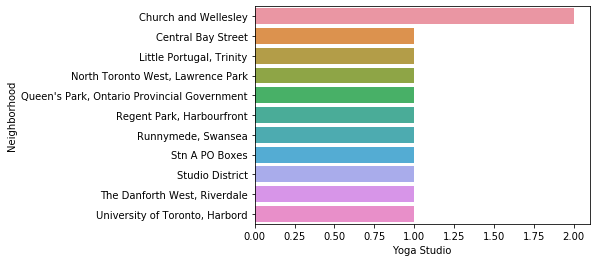

In [36]:
yoga = pd.DataFrame(toronto_onehot[(toronto_onehot["Yoga Studio"]==1)]
             .groupby(['Neighborhood'])
             .count()['Yoga Studio']).reset_index().sort_values(by=['Yoga Studio'],ascending=False)

ax = sns.barplot(y='Neighborhood', x='Yoga Studio', data= yoga)

In [37]:
yoga_neighboord_list = list(yoga['Neighborhood']) 

In [38]:
yoga_neighboord_list

['Church and Wellesley',
 'Central Bay Street',
 'Little Portugal, Trinity',
 'North Toronto West, Lawrence Park',
 "Queen's Park, Ontario Provincial Government",
 'Regent Park, Harbourfront',
 'Runnymede, Swansea',
 'Stn A PO Boxes',
 'Studio District',
 'The Danforth West, Riverdale',
 'University of Toronto, Harbord']

### Finding Neighborhood of Healthy Places

Healthy places are grouped as Salad Place, Vegetarian / Vegan Restaurant and Spa

In [39]:
healthy = pd.DataFrame(toronto_onehot[((toronto_onehot['Salad Place']==1) |(toronto_onehot['Vegetarian / Vegan Restaurant']==1)
                                      |(toronto_onehot['Spa']==1))
                           & ((~(toronto_onehot['Salad Place'].isin(yoga_neighboord_list)))
                               &(~(toronto_onehot['Vegetarian / Vegan Restaurant'].isin(yoga_neighboord_list)))
                                 &(~(toronto_onehot['Spa'].isin(yoga_neighboord_list))))]
                  .groupby(['Neighborhood']).count()[['Salad Place']]
            ).reset_index().sort_values(by=['Salad Place'],ascending=False)

healthy

,Neighborhood,Salad Place
17,"Toronto Dominion Centre, Design Exchange",5
2,Central Bay Street,4
4,"First Canadian Place, Underground city",4
3,"Commerce Court, Victoria Hotel",3
11,"Richmond, Adelaide, King",3
6,"Harbourfront East, Union Station, Toronto Islands",2
7,"Kensington Market, Chinatown, Grange Park",2
8,"Little Portugal, Trinity",2
12,"Runnymede, Swansea",2
13,St. James Town,1


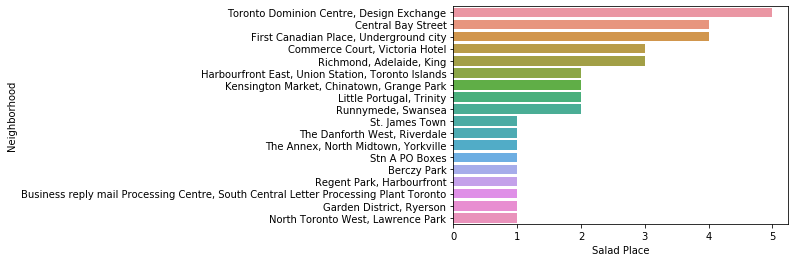

In [41]:
ax = sns.barplot(y='Neighborhood', x='Salad Place', data= healthy)

### Finding Neighborhood of Sports Places

Sports places are grouped as Gyms and Gym / Fitness Center

In [43]:
sports=pd.DataFrame(toronto_onehot[(toronto_onehot["Gym / Fitness Center"]==1) |(toronto_onehot["Gym"]==1)
                                    & ((~(toronto_onehot['Gym / Fitness Center'].isin(yoga_neighboord_list)))
                               &(~(toronto_onehot['Gym'].isin(yoga_neighboord_list))))]
                  .groupby(["Neighborhood"])
             .count()[["Gym / Fitness Center",'Gym']]).reset_index().sort_values(by=["Gym / Fitness Center",'Gym'],ascending=False)

sports

,Neighborhood,Gym / Fitness Center,Gym
3,"Commerce Court, Victoria Hotel",5,5
6,"First Canadian Place, Underground city",5,5
14,"Richmond, Adelaide, King",4,4
4,Davisville,2,2
5,Davisville North,2,2
7,"Garden District, Ryerson",2,2
16,St. James Town,2,2
17,Stn A PO Boxes,2,2
19,"Toronto Dominion Centre, Design Exchange",2,2
0,"Brockton, Parkdale Village, Exhibition Place",1,1


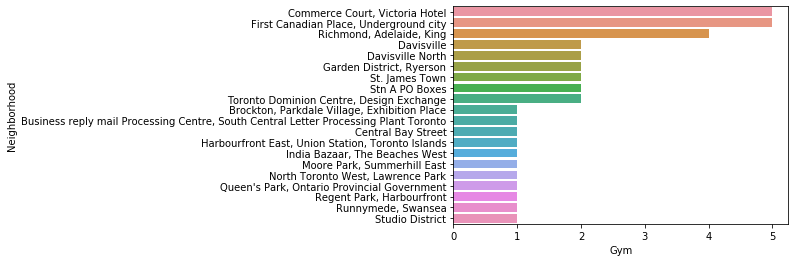

In [44]:
ax = sns.barplot(y="Neighborhood", x='Gym',data=sports)

### Combination of healthy and sports places

In [48]:
combination = healthy.merge(sports,on='Neighborhood',how='outer').fillna(0)
combination['total'] = combination['Salad Place'] + combination['Gym']
combination

,Neighborhood,Salad Place,Gym / Fitness Center,Gym,total
0,"Toronto Dominion Centre, Design Exchange",5.0,2.0,2.0,7.0
1,Central Bay Street,4.0,1.0,1.0,5.0
2,"First Canadian Place, Underground city",4.0,5.0,5.0,9.0
3,"Commerce Court, Victoria Hotel",3.0,5.0,5.0,8.0
4,"Richmond, Adelaide, King",3.0,4.0,4.0,7.0
5,"Harbourfront East, Union Station, Toronto Islands",2.0,1.0,1.0,3.0
6,"Kensington Market, Chinatown, Grange Park",2.0,0.0,0.0,2.0
7,"Little Portugal, Trinity",2.0,0.0,0.0,2.0
8,"Runnymede, Swansea",2.0,1.0,1.0,3.0
9,St. James Town,1.0,2.0,2.0,3.0


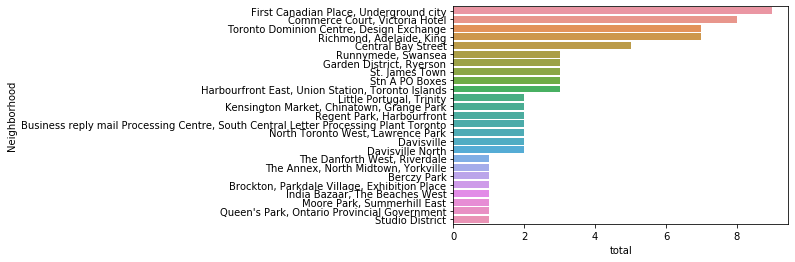

In [49]:
combination=combination.sort_values(by=['total'],ascending=False)
ax = sns.barplot(y="Neighborhood", x='total',data=combination)